# Visualization for `results/15_00.csv`
Notebook này đọc kết quả benchmark và vẽ các hình dùng cho báo cáo.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 130
plt.rcParams['savefig.dpi'] = 160

REPO_ROOT = Path.cwd()
if not (REPO_ROOT / 'results').exists():
    REPO_ROOT = REPO_ROOT.parent

CSV_PATH = REPO_ROOT / 'results' / '15_00.csv'
OUT_DIR = REPO_ROOT / 'report' / 'figures'
OUT_DIR.mkdir(parents=True, exist_ok=True)

print('REPO_ROOT =', REPO_ROOT)
print('CSV_PATH  =', CSV_PATH)
print('OUT_DIR   =', OUT_DIR)
assert CSV_PATH.exists(), f'Missing CSV: {CSV_PATH}'


REPO_ROOT = /Users/anhoaithai/Documents/AHT/1. PROJECTS/ASR_Benchmark/vn-streaming-asr-bench
CSV_PATH  = /Users/anhoaithai/Documents/AHT/1. PROJECTS/ASR_Benchmark/vn-streaming-asr-bench/results/15_00.csv
OUT_DIR   = /Users/anhoaithai/Documents/AHT/1. PROJECTS/ASR_Benchmark/vn-streaming-asr-bench/report/figures


In [2]:
df = pd.read_csv(CSV_PATH)

def parse_model(run_id: str) -> str:
    if '__chunkformer_ctc_large_vie__' in run_id:
        return 'ChunkFormer-CTC-large'
    if '__wav2vec2_base_vn_250h__' in run_id:
        return 'wav2vec2-base-vi'
    if '__pho_whisper_large__' in run_id:
        return 'PhoWhisper-large'
    if '__whisper_large_v3__' in run_id:
        return 'Whisper-large-v3'
    return 'Unknown'

def parse_dataset(run_id: str) -> str:
    key = run_id.split('__')[0]
    mapping = {
        'vivos_300': 'VIVOS',
        'vlsp2020_300': 'VLSP2020',
        'viet_youtube_asr_v2_300': 'Viet YouTube ASR v2',
        'speech_massive_vie_300': 'Speech-MASSIVE_vie',
    }
    return mapping.get(key, key)

df['model'] = df['run_id'].map(parse_model)
df['dataset'] = df['run_id'].map(parse_dataset)
df['mode_label'] = df['mode'].map({0.0: 'offline', 1.0: 'streaming'})

# convert to percentage for reporting plots
for c in ['offline_wer', 'offline_wer_ci_low', 'offline_wer_ci_high',
          'streaming_wer', 'streaming_wer_ci_low', 'streaming_wer_ci_high', 'delta_wer']:
    if c in df.columns:
        df[c + '_pct'] = df[c] * 100.0

dataset_order = ['VIVOS', 'VLSP2020', 'Viet YouTube ASR v2', 'Speech-MASSIVE_vie']
model_order = ['ChunkFormer-CTC-large', 'wav2vec2-base-vi', 'PhoWhisper-large', 'Whisper-large-v3']
stream_model_order = ['ChunkFormer-CTC-large', 'wav2vec2-base-vi']

print(df[['run_id', 'dataset', 'model', 'mode_label']].head())
print('rows =', len(df))


                                              run_id              dataset  \
0  speech_massive_vie_300__chunkformer_ctc_large_...   Speech-MASSIVE_vie   
1  speech_massive_vie_300__pho_whisper_large__off...   Speech-MASSIVE_vie   
2  speech_massive_vie_300__wav2vec2_base_vn_250h_...   Speech-MASSIVE_vie   
3  speech_massive_vie_300__whisper_large_v3__offline   Speech-MASSIVE_vie   
4  viet_youtube_asr_v2_300__chunkformer_ctc_large...  Viet YouTube ASR v2   

                   model mode_label  
0  ChunkFormer-CTC-large  streaming  
1       PhoWhisper-large    offline  
2       wav2vec2-base-vi  streaming  
3       Whisper-large-v3    offline  
4  ChunkFormer-CTC-large  streaming  
rows = 16


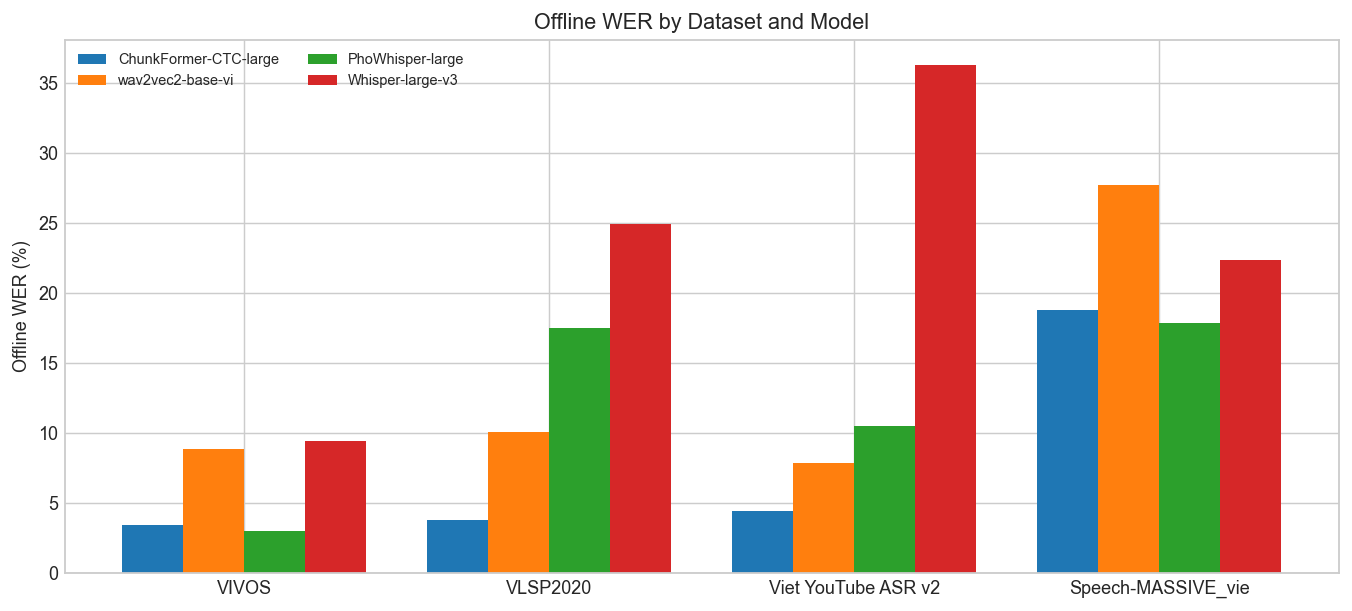

In [9]:
# Figure 1: Offline WER by dataset/model
offline = df[df['offline_wer'].notna()].copy()
pivot_off = offline.pivot_table(
    index='dataset',
    columns='model',
    values='offline_wer_pct',
    aggfunc='first'
)
pivot_off = offline.pivot(index='dataset', columns='model', values='offline_wer_pct')
pivot_off = pivot_off.reindex(index=dataset_order, columns=model_order)

fig, ax = plt.subplots(figsize=(10.5, 4.8))
x = np.arange(len(pivot_off.index))
w = 0.2
for i, m in enumerate(model_order):
    ax.bar(x + (i - 1.5) * w, pivot_off[m].values, width=w, label=m)

ax.set_xticks(x)
ax.set_xticklabels(pivot_off.index, rotation=0)
ax.set_ylabel('Offline WER (%)')
ax.set_title('Offline WER by Dataset and Model')
ax.legend(ncol=2, fontsize=8)
fig.tight_layout()
fig.savefig(OUT_DIR / 'fig_offline_wer_bar.png')
plt.show()


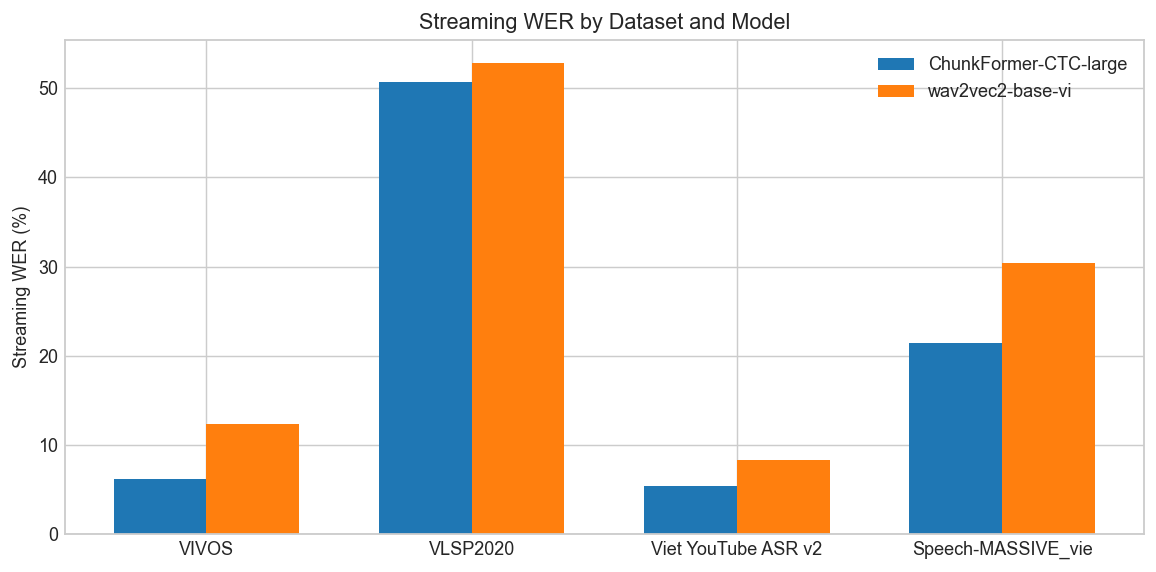

In [4]:
# Figure 2: Streaming WER by dataset/model
stream = df[df['mode'] == 1.0].copy()
pivot_st = stream.pivot(index='dataset', columns='model', values='streaming_wer_pct')
pivot_st = pivot_st.reindex(index=dataset_order, columns=stream_model_order)

fig, ax = plt.subplots(figsize=(9.0, 4.5))
x = np.arange(len(pivot_st.index))
w = 0.35
for i, m in enumerate(stream_model_order):
    ax.bar(x + (i - 0.5) * w, pivot_st[m].values, width=w, label=m)

ax.set_xticks(x)
ax.set_xticklabels(pivot_st.index, rotation=0)
ax.set_ylabel('Streaming WER (%)')
ax.set_title('Streaming WER by Dataset and Model')
ax.legend()
fig.tight_layout()
fig.savefig(OUT_DIR / 'fig_streaming_wer_bar.png')
plt.show()


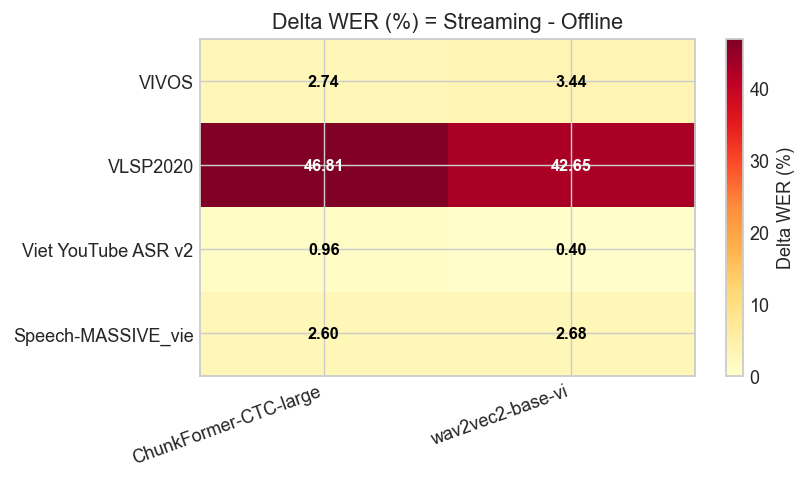

In [10]:
# Figure 3: Delta WER heatmap (streaming - offline)
pivot_delta = stream.pivot(index='dataset', columns='model', values='delta_wer_pct')
pivot_delta = pivot_delta.reindex(index=dataset_order, columns=stream_model_order)

fig, ax = plt.subplots(figsize=(6.5, 3.8))
im = ax.imshow(pivot_delta.values, cmap='YlOrRd', aspect='auto', vmin=0)

ax.set_xticks(np.arange(len(stream_model_order)))
ax.set_xticklabels(stream_model_order, rotation=20, ha='right')
ax.set_yticks(np.arange(len(dataset_order)))
ax.set_yticklabels(dataset_order)
ax.set_title('Delta WER (%) = Streaming - Offline')

norm = im.norm
for i in range(pivot_delta.shape[0]):
    for j in range(pivot_delta.shape[1]):
        val = pivot_delta.iloc[i, j]
        r, g, b, _ = im.cmap(norm(val))
        luminance = 0.2126 * r + 0.7152 * g + 0.0722 * b
        text_color = 'white' if luminance < 0.45 else 'black'
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color=text_color, fontsize=9, fontweight='semibold')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Delta WER (%)')
fig.tight_layout()
fig.savefig(OUT_DIR / 'fig_delta_wer_heatmap.png')
plt.show()


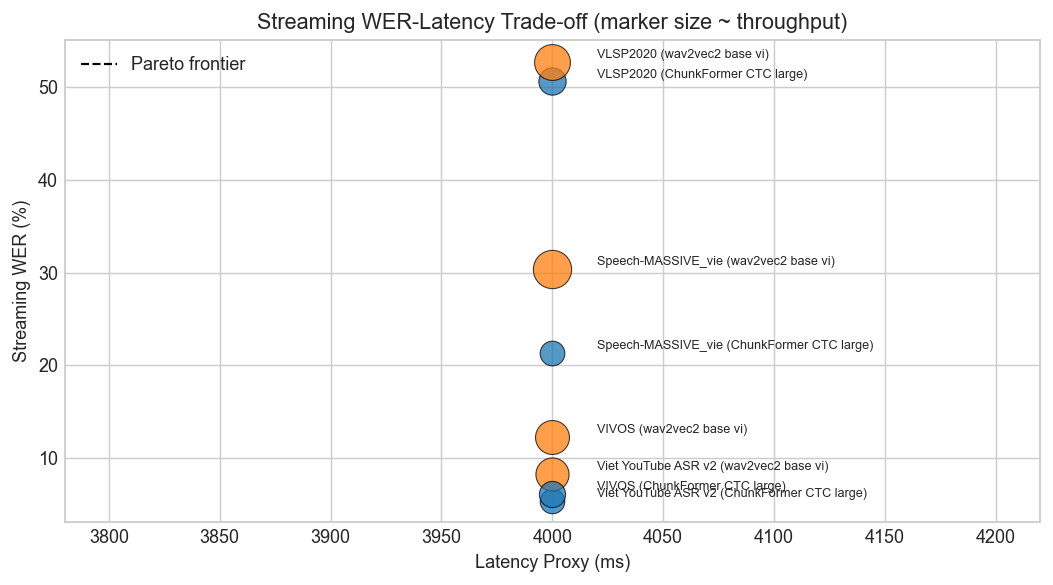

In [6]:
# Figure 4: Pareto-style scatter (streaming only)
st = stream.copy()
st['latency_ms'] = st['streaming_latency_proxy_ms']
st['wer_pct'] = st['streaming_wer_pct']
st['rtf'] = st['streaming_rtf']
st['size'] = (1.0 / st['rtf']).clip(lower=20, upper=220)

color_map = {
    'ChunkFormer-CTC-large': '#1f77b4',
    'wav2vec2-base-vi': '#ff7f0e',
}

fig, ax = plt.subplots(figsize=(8.2, 4.6))
for _, r in st.iterrows():
    ax.scatter(r['latency_ms'], r['wer_pct'],
               s=float(r['size']) * 2.2,
               color=color_map.get(r['model'], '#999999'),
               alpha=0.75, edgecolor='black', linewidth=0.6)
    ax.text(r['latency_ms'] + 20, r['wer_pct'] + 0.4,
            f"{r['dataset']} ({r['model'].replace('-',' ')})", fontsize=7)

# Pareto frontier (min latency, min WER)
pts = st[['latency_ms', 'wer_pct']].sort_values(['latency_ms', 'wer_pct']).to_numpy()
pareto = []
best = float('inf')
for x, y in pts:
    if y <= best:
        pareto.append((x, y))
        best = y
if pareto:
    px, py = zip(*pareto)
    ax.plot(px, py, '--', color='black', linewidth=1.2, label='Pareto frontier')

ax.set_xlabel('Latency Proxy (ms)')
ax.set_ylabel('Streaming WER (%)')
ax.set_title('Streaming WER-Latency Trade-off (marker size ~ throughput)')
ax.legend(loc='upper left')
fig.tight_layout()
fig.savefig(OUT_DIR / 'fig_pareto_streaming.png')
plt.show()


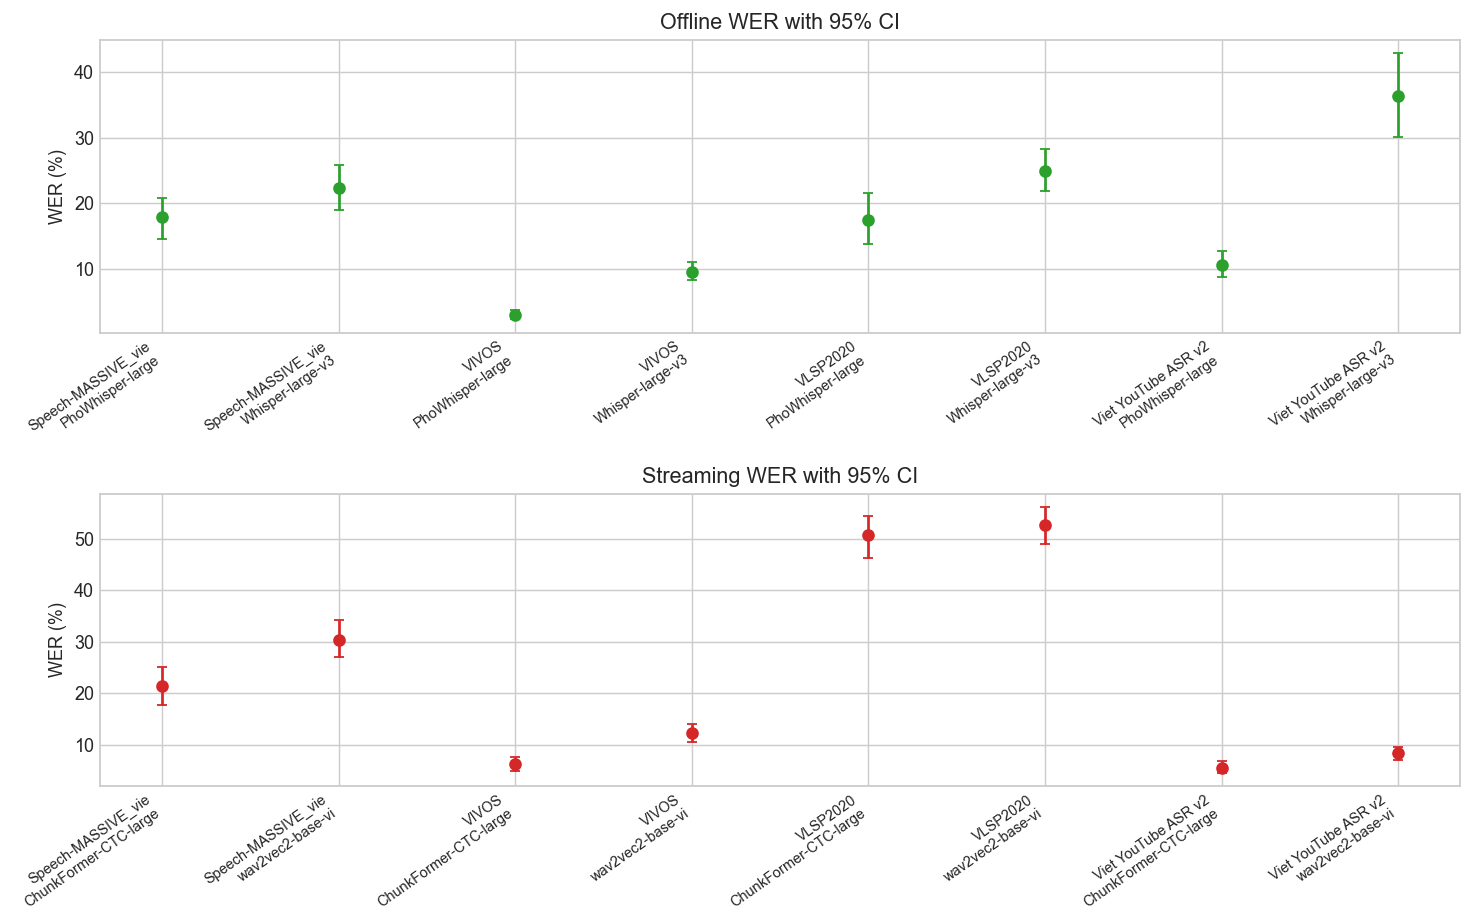

In [7]:
# Figure 5: WER + 95% CI (offline and streaming)
fig, axes = plt.subplots(2, 1, figsize=(11.5, 7.2), sharex=False)

# Offline CI
off = df[df['mode'] == 0.0].copy()
off = off.sort_values(['dataset', 'model'])
x = np.arange(len(off))
y = off['offline_wer_pct'].values
lo = off['offline_wer_ci_low_pct'].values
hi = off['offline_wer_ci_high_pct'].values
err = np.vstack([y - lo, hi - y])
axes[0].errorbar(x, y, yerr=err, fmt='o', capsize=3, color='#2ca02c')
axes[0].set_title('Offline WER with 95% CI')
axes[0].set_ylabel('WER (%)')
axes[0].set_xticks(x)
axes[0].set_xticklabels((off['dataset'] + '\n' + off['model']).tolist(), rotation=35, ha='right', fontsize=8)

# Streaming CI
st = df[df['mode'] == 1.0].copy()
st = st.sort_values(['dataset', 'model'])
x2 = np.arange(len(st))
y2 = st['streaming_wer_pct'].values
lo2 = st['streaming_wer_ci_low_pct'].values
hi2 = st['streaming_wer_ci_high_pct'].values
err2 = np.vstack([y2 - lo2, hi2 - y2])
axes[1].errorbar(x2, y2, yerr=err2, fmt='o', capsize=3, color='#d62728')
axes[1].set_title('Streaming WER with 95% CI')
axes[1].set_ylabel('WER (%)')
axes[1].set_xticks(x2)
axes[1].set_xticklabels((st['dataset'] + '\n' + st['model']).tolist(), rotation=35, ha='right', fontsize=8)

fig.tight_layout()
fig.savefig(OUT_DIR / 'fig_wer_ci_offline_streaming.png')
plt.show()


In [8]:
generated = sorted(OUT_DIR.glob('fig_*.png'))
print('Generated figures:')
for p in generated:
    print('-', p.relative_to(REPO_ROOT))

summary_cols = ['run_id', 'mode_label', 'offline_wer_pct', 'streaming_wer_pct', 'delta_wer_pct', 'rtf']
display(df[summary_cols].sort_values(['mode_label', 'run_id']))


Generated figures:
- report/figures/fig_delta_wer_heatmap.png
- report/figures/fig_offline_wer_bar.png
- report/figures/fig_pareto_streaming.png
- report/figures/fig_streaming_wer_bar.png
- report/figures/fig_wer_ci_offline_streaming.png


,run_id,mode_label,offline_wer_pct,streaming_wer_pct,delta_wer_pct,rtf
1,speech_massive_vie_300__pho_whisper_large__off...,offline,17.850213,NaN,NaN,0.080750
3,speech_massive_vie_300__whisper_large_v3__offline,offline,22.390376,NaN,NaN,0.067623
5,viet_youtube_asr_v2_300__pho_whisper_large__of...,offline,10.547593,NaN,NaN,0.124670
7,viet_youtube_asr_v2_300__whisper_large_v3__off...,offline,36.273429,NaN,NaN,0.121726
9,vivos_300__pho_whisper_large__offline,offline,3.010949,NaN,NaN,0.099376
11,vivos_300__whisper_large_v3__offline,offline,9.489051,NaN,NaN,0.086935
13,vlsp2020_300__pho_whisper_large__offline,offline,17.488942,NaN,NaN,0.107409
15,vlsp2020_300__whisper_large_v3__offline,offline,24.914937,NaN,NaN,0.093764
0,speech_massive_vie_300__chunkformer_ctc_large_...,streaming,18.781529,21.381451,2.599922,0.011757
2,speech_massive_vie_300__wav2vec2_base_vn_250h_...,streaming,27.706636,30.384168,2.677532,0.004892
